In [36]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
from sklearn.decomposition import PCA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, get_T_inds, make_dendro, gen_trials_from_model_dir,take_names

In [12]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v5_figs','paper_figs','fig5','stim_range')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [13]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains = ['fdgo', 'delaygo', 'fdanti']

rule_trains_str = '_'.join(rule_trains)

# parse input arguments as:
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'all'
n_tasks = str(len(rule_trains))
n_rnn = str(128)
l2w = float(-6)
l2h = float(-6)
l1w = float(0)
l1h = float(0)
lr = float(-6)
seed = str(0)
sigma_rec = 1/20
sigma_x = 2/20
w_rec_coeff  = 8/10
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'final1'

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

m = os.path.join(p,'data','rnn','multitask',net,data_folder,ruleset,
                        rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                        str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))

# m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

model = FixedPoint_Model(m)
hp = model.hp

Overwrite sigma_rec with 0.000


In [14]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

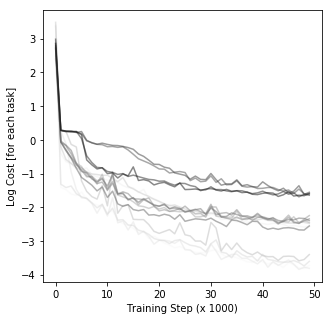

In [15]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

task_list = rule_trains

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
#     plt.ylim([-6,2])
    
# plt.title(m)
plt.show()    

In [16]:
def make_label_sets(rule_trains):
    label_set = {}
    label_set['anti'] = [('anti' in rule) or ('nogo' in rule) for rule in rule_trains]
    label_set['delay'] = [('delay' in rule) or ('fd' in rule) for rule in rule_trains]
    label_set['dm2'] = ['dm2' in rule for rule in rule_trains]
    label_set['dm1'] = ['dm1' in rule for rule in rule_trains]
    label_set['dmc'] = ['dmc' in rule for rule in rule_trains]
    label_set['react'] = ~np.array(label_set['delay'])

    label_reverse_set = {}
    label_reverse_set['anti'] = ~np.array(label_set['anti'])
    label_reverse_set['delay'] = ~np.array(label_set['delay'])
    label_reverse_set['dm2'] = ['dm1' in rule for rule in rule_trains]
    label_reverse_set['dm1'] = ['dm2' in rule for rule in rule_trains]
    label_reverse_set['dmc'] = ~np.array(label_set['dmc'])
    label_reverse_set['react'] = ~np.array(label_set['react'])
    return label_set, label_reverse_set

In [17]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains = ['fdgo', 'delaygo', 'fdanti']

rule_trains_str = '_'.join(rule_trains)

# parse input arguments as:
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'lr'
n_tasks = str(len(rule_trains))
n_rnn = str(128)
l2w = float(-6)
l2h = float(-6)
l1w = float(0)
l1h = float(0)
lr = float(-6)
seed = str(1)
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/'

In [18]:
# set of networks to compare
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
data_folder ='final'
color_set = {}
color_set['lr'] = 'k'
color_set['untrained'] = 'dodgerblue'
color_set['no_noise'] = 'orangered'

seed_set = [str(1),]
max_d = 20
n_rnn = str(128)
x_ind_counter = 0
ax1_xticks = []
method = 'average'
criterion = 'maxclust'
all_epochs = ['stim1','stim2','delay1','delay2','go1']
n_tasks = str(len(rule_trains))
seed = 1
lr = -7
sigma_rec = 1/20
sigma_x = 2/20
ruleset = 'all'
w_rec_coeff  = 8/10
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# data_folder_all = 'data/rnn/multitask/stepnet/'

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

m = os.path.join(p,'data','rnn','multitask',net,data_folder,ruleset,
                        rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                        str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
m = os.path.join(p,'data','rnn','multitask',net,'final','all',rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,str(seed))

In [19]:
# method = 'ward'
# max_d = 2.5
# criterion = 'distance'
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(max_d)
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))

perfs_changes = lesion_var['perfs_changes']

In [20]:
rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'IntegrationModality1', 'IntegrationModality2', 'ContextIntModality1', 'ContextIntModality2', 'IntegrationMultimodal',
              'ReactMatch2Sample', 'ReactNonMatch2Sample', 'ReactCategoryPro', 'ReactCategoryAnti']

In [21]:
rule_names = {'fdgo':'DelayPro', 
              'reactgo':'ReactPro', 
              'delaygo':'MemoryPro', 
              'fdanti':'DelayAnti', 
              'reactanti':'ReactAnti',
              'delayanti':'MemoryAnti',
              'delaydm1':'DelayD1', 
              'delaydm2':'DelayD2', 
              'contextdelaydm1':'ContextDelayD1', 
              'contextdelaydm2':'ContextDelayD2', 
              'multidelaydm':'MultiDelayD',
              'dmsgo':'DM2SamplePro', 
              'dmsnogo':'DM2SampleAnti', 
              'dmcgo':'DM2CategoryPro', 
              'dmcnogo':'DM2CategoryAnti'}

In [22]:
label_set,label_reverse_set = make_label_sets(rule_trains)

In [23]:
import matplotlib.patches as mpatches
from scipy.cluster import hierarchy
color_palette = ['b','c', 'm', 'y', 'r']
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z'}

In [24]:
# from network import get_perf
# from task import generate_trials
# from tools_lnd import take_names

# fontsize = 20
# tick_fontsize = fontsize*.75
# label_fontsize = fontsize*1
# plt.rcParams.update({'font.size': fontsize})

# def plot_lesion(m,task_list,epoch,lesion_units_list,cluster_label = [],lesion_num = []):

#     fig = plt.figure(figsize=(4, 4))
#     cmap = plt.get_cmap('hsv')
# #     c_full = cmap(0.1)
# #     c_lesion = cmap(.6)
#     c_full = 'dodgerblue'
#     c_lesion = 'r'#'brown'
#     al = .5
#     lw = 6
    
#     from tools_lnd import get_model_params
#     w_in, b_in, w_out, b_out = get_model_params(m)

#     D_out = {}
#     D_out['axes'] = w_out[:,1:]
#     D_out['labels'] = ['W_{out} cos(theta)','W_{out} sin(theta)']

#     model = FixedPoint_Model(m)
#     hp = model.hp
#     with tf.Session() as sess:
#         model.restore()
#         model._sigma=0
#         if len(lesion_units_list)>0:
#             model.lesion_units(sess, lesion_units_list)

#         for ri in range(len(task_list)):
#             rule = task_list[ri]
#             trial = generate_trials(rule, hp, 'test', noise_on = False)
#             feed_dict = tools.gen_feed_dict(model, trial, hp)
#             h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            
#             _components = 3
#             pca = PCA(n_components = n_components)
#             D_pca = {}
            
#             if epoch in trial.epochs.keys():
#                 T_inds = get_T_inds(trial,epoch) # grab epoch time indexing
#             else:
#                 T_inds = get_T_inds(trial,'go1')
                
#             h =  np.transpose(h_all_byrule[rule][T_inds,:,:],(2,1,0))# h_tf[:,range(1,n_trials),:],(2,1,0))
#             Xh = np.reshape(h,(h.shape[0],-1))
#             fp_pca = pca.fit_transform(Xh.T)
#             D_pca['axes'] = pca.components_.T
#             D_pca['labels'] = ['PCA '+str(x+1) for x in range(n_components)]

#             for trial_i in range(3,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/20)): #includes mod2 trials
#                 c = cmap(trial.y_loc[-1,trial_i]/(2*np.pi))

# #                 ax = plt.subplot(len(task_list),2,1+(2*ri))
#                 ax = fig.add_axes([0,ri*.6,.3,.3]);
#                 X_rule = np.dot(h_all_byrule[rule][:,trial_i,:],D_pca['axes'])
#                 plt.plot(X_rule[:,0],X_rule[:,1],c = c_full,alpha = al,linewidth = lw)
#                 plt.plot(X_rule[-1,0],X_rule[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

#                 X_dot = np.dot(h_tf[:,trial_i,:],D_pca['axes'])
#                 plt.plot(X_dot[:,0],X_dot[:,1],c = c_lesion,alpha = al,linewidth = lw)
#                 plt.plot(X_dot[-1,0],X_dot[-1,1],'^',c = c_lesion,alpha = al,linewidth = lw)
                
#                 _, rule_name, _, _ = take_names(epoch,rule)
#                 plt.title(cluster_label[ri]+r"$\bf{" + rule_name + "}$", y=.98, x = 1)

#                 plt.xlabel(D_pca['labels'][0])
#                 plt.ylabel(D_pca['labels'][1])
#                 ax.spines['right'].set_visible(False)
#                 ax.spines['top'].set_visible(False) 
#                 ax.spines['bottom'].set_visible(False)
#                 ax.spines['left'].set_visible(False)  
#                 ax.set_xticks([]) 
#                 ax.set_yticks([])

# #                 ax = plt.subplot(len(task_list),2,2+(2*ri))
#                 ax = fig.add_axes([.5,ri*.6,.3,.3]);
#                 X_rule = np.dot(h_all_byrule[rule][:,trial_i,:],D_out['axes'])
#                 plt.plot(X_rule[:,0],X_rule[:,1],c = c_full,alpha = al,linewidth = lw)
#                 plt.plot(X_rule[-1,0],X_rule[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

#                 X_dot = np.dot(h_tf[:,trial_i,:],D_out['axes'])
#                 plt.plot(X_dot[:,0],X_dot[:,1],c = c_lesion,alpha = al,linewidth = lw)
#                 plt.plot(X_dot[-1,0],X_dot[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

#                 plt.xlabel('OUT 1')
#                 plt.ylabel('OUT 2')
#                 ax.spines['right'].set_visible(False)
#                 ax.spines['top'].set_visible(False) 
#                 ax.spines['bottom'].set_visible(False)
#                 ax.spines['left'].set_visible(False)  
#                 ax.set_xticks([]) 
#                 ax.set_yticks([])
                

#     figname = 'viz_traj_'+'_'.join(task_list)+str(lesion_num)
#     plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')

In [25]:
# h_all_byepoch, h_all_byrule, _, _ = make_h_all(m,mode = 'test')

In [26]:
cluster_number = {}
cluster_number['Anti'] = 5
cluster_number['Delayed Response'] = 2
cluster_number['Modality2'] = 10
cluster_number['Modality1'] = 6
cluster_names = ['Anti','Delayed Response','Modality2','Modality1']

In [27]:
# from tools_lnd import remove_spines, get_xlim_diff, get_ylim_diff
# def make_lil_axes(ax,axes_labels,fontsize = 20,fac_len = 10):
    
#     remove_spines(ax)

#     x1,x2,x_diff = get_xlim_diff(ax)
#     y1,y2,y_diff = get_ylim_diff(ax)
    
#     if len(axes_labels)>2:
#         z1,z2,z_diff = get_zlim_diff(ax)
        
#         plt.plot([x1,x1+x_diff/fac_len],[y1,y1],[z1,z1],'-k')
#         plt.plot([x1,x1],[y1,y1+y_diff/fac_len],[z1,z1],'-k')
#         plt.plot([x1,x1],[y1,y1],[z1,z1+z_diff/fac_len],'-k')
        
#         ax.text(x1,y1-y_diff/8,z1,axes_labels[0],(1,0,0),
#             horizontalalignment='left',
#             verticalalignment='top',
#                  fontsize = fontsize)
#         ax.text(x1-x_diff/8,y1+y_diff/5,z1,axes_labels[1],(0,1,0),
#             horizontalalignment='left',
#             verticalalignment='bottom',
#                  fontsize = fontsize)
#         ax.text(x1-x_diff/15,y1,z1+z_diff/5,axes_labels[2],
#             horizontalalignment='right',
#             verticalalignment='bottom',
#                  fontsize = fontsize)
        
#         ax.set_zticks([])
        
#     else:
#         plt.plot([x1,x1+x_diff/10],[y1,y1],'-k')
#         plt.plot([x1,x1],[y1,y1+y_diff/10],'-k')

#         plt.text(x1,y1-y_diff/50,axes_labels[0],
#             horizontalalignment='left',
#             verticalalignment='top',
#                  fontsize = fontsize)
#         plt.text(x1-x_diff/10,y1,axes_labels[1], #/6
#             horizontalalignment='left',
#             verticalalignment='bottom',
#                  fontsize = fontsize,
#                  rotation = 90)
        
#     ax.set_yticks([])
#     ax.set_xticks([])

In [28]:
# from tools_lnd import make_FP_axs, get_model_params #get_filename, 
# def compare_fp_lesions(m,cluster_var,lesion_cluster,rule_set,color_by = 'stim',n_components = 3,fontsize=20,
#                        review = False, epoch_set = [], q_thresh = 1e-3,t = 0, ri_axs = 0, view_init = [-51,30], 
#                        epoch_ri=[]):
    
#     if review:
#         lf = 'lesion_fps_review'
#     else:
#         lf = 'lesion_fps'
        
#     lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
#     cmap = plt.get_cmap('hsv')
#     c_full = 'dodgerblue'#cmap(0.1)
#     c_lesion = 'r'#'brown'#cmap(.6)
#     h_all_byepoch, h_all_byrule, _, _ = make_h_all(m)
    
#     plt.rcParams.update({'font.size': fontsize})
#     tick_fontsize = fontsize*.75
#     label_fontsize = fontsize*1

#     for ri in range(len(task_list)):
#         rule = task_list[ri]
#         trial = gen_trials_from_model_dir(m,rule,noise_on = False)
#         B = np.shape(trial.y_loc)[1]
#         N = np.shape(trial.y_loc)[1]
#         trial_set = range(0,B,int(B/10))
        
#         if len(epoch_ri)==0:
#             epoch = epoch_set[ri_axs]
#         else:
#             epoch =  epoch_ri  
            
#         rule = rule_set[ri_axs]
#         trial = gen_trials_from_model_dir(m,rule,noise_on = False)
#         filename,_ = get_filename(trial,epoch,t)
#         f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')    
#         D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')
#         w_in, b_in, w_out, b_out = get_model_params(m)

# #         D_use = -D_use
#         if rule == 'delaygo':
#             D_use = -D_use
#         else:
#             D_use[:,1] = -D_use[:,1]
            
#         D_use[:,2] = w_out[:,2]
#         axes_labels = [epoch, rule]

#         epoch_list = sorted(trial.epochs.items(), key=lambda x: x[1])
        
#         if len(epoch_set)==0:
#             epoch_set = [epoch_list[x][0] for x in range(len(epoch_list))]

#         for trial_num in [t,]:##range(0,B,int(B/5))
#             out_theta = int(180*trial.y_loc[-1,trial_num]/np.pi)

#             for plot_num in range(0,len(epoch_set)):
                
#                 fig = plt.figure(figsize=(7,7),tight_layout=True,facecolor='white')

#                 epoch = epoch_set[plot_num]
#                 epoch_name, task_name, _, _ = take_names(epoch,rule)

#                 ax = plt.subplot(1,1,1, projection='3d')
#                 w_color = .005
#                 ax.w_xaxis.set_pane_color((w_color, w_color, w_color, w_color))
#                 ax.w_yaxis.set_pane_color((w_color, w_color, w_color, w_color))
#                 ax.w_zaxis.set_pane_color((w_color, w_color, w_color, w_color))

#                 lesion_units_list = cluster_var['lesion_units_list'][lesion_cluster]
                
#                 if epoch[0]=='s':
#                     filename,_ = get_filename_fp(trial,epoch,trial_num)
#                 elif rule[0]=='d':
#                     filename,_ = get_filename_fp(trial,epoch,0)
#                 else:
#                     filename,_ = get_filename_fp(trial,epoch,trial_num)
                    
#                 f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(lesion_cluster),rule,filename)
#                 c = c_lesion
                
#                 plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num,epoch,f,
#                                          rand_step_coef = 0,
#                                          al = .2, 
#                                          linestyle = '-', 
#                                          n_steps = 60,
#                                          n_jit = 0
#                                          ,c = c, 
#                                          q_thresh = q_thresh)

#                 lesion_units_list = []
                
#                 if epoch[0]=='s':
#                     filename,_ = get_filename_fp(trial,epoch,trial_num)
#                 elif rule[0]=='d':
#                     filename,_ = get_filename_fp(trial,epoch,0)
#                 else:
#                     filename,_ = get_filename_fp(trial,epoch,trial_num)
                    
#                 f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(0),rule,filename)
#                 c = c_full

#                 plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num,epoch,f,
#                                          rand_step_coef = 0,
#                                          al = .2, 
#                                          linestyle = '-', 
#                                          n_steps = 60,
#                                          n_jit = 0,
#                                          c = c, 
#                                          q_thresh = q_thresh)

#                 tit = 'Task : '+ r"$\bf{" + task_name + "}$" +'\n Period : '+ r"$\bf{" + epoch_name.capitalize() + "}$"
#                 plt.title(tit,fontsize = fontsize,y = .9)

#                 ax.set_xlim([-1.2,1.2])
#                 ax.set_ylim([-1.2,1.2]) 
#                 make_ax_nice(ax,axes_labels)
                
#                 ax.set_yticks([])
#                 ax.set_xticks([])
#                 ax.set_zticks([])
                
#                 ax.view_init(azim=view_init[0], elev=view_init[1]) #(azim=-51, elev=30)
#                 ax.dist = 12
            

#                 figname = 'lesion'+str(lesion_cluster)+'_'+rule+'_'+epoch+'_'+str(out_theta)
#                 if not os.path.exists(os.path.join(figpath,'vis_fp_lesion')):
#                     os.makedirs(os.path.join(figpath,'vis_fp_lesion'))
#                 plt.savefig(os.path.join(figpath,'vis_fp_lesion',figname+'.pdf'))
#                 plt.show()

In [29]:
# def plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,t_num,fp_epoch,f,
#                    xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
#                    lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k', q_thresh = 1e-3):#, q_thresh = 1e-8

#     ms = 20
#     lw = 6
    
#     fp_struct = np.load(f)
#     step_fps = fp_struct['xstar']
    
# #     if fp_epoch=='stim1':
# #         fp_use = np.where(fp_struct['qstar']<q_thresh/100)[0] 
# #     else:
# #         fp_use = np.where(fp_struct['qstar']<q_thresh)[0]
        
#     fp_use = np.where(fp_struct['qstar']<q_thresh)[0]
    
    
#     sorted_fps = fp_struct['xstar'][fp_use,:]
  
#     fp_project = np.dot(sorted_fps,D_use)

#     # runs jitters around fps
#     stable = np.empty(len(sorted_fps))
#     for fp_ind in range(len(sorted_fps)):

#         dst_scale = 300

#         facecolors_3d = c
#         facecolors_2d = c
#         edgecolors = 'w'

#         for jit in range(n_jit):
#             h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
#             h_t = vanilla_run_with_h0(params, x_t, h0, hp)
#             jitter = np.dot(h_t,D_use)
#             ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = 3)


#         if fp_epoch=='stim1':
#             ax.scatter(fp_project[fp_ind,0],fp_project[fp_ind,1],fp_project[fp_ind,2],'o',
#                       s = dst_scale, edgecolors = edgecolors, facecolors = facecolors_3d, alpha = al)
#         else:
#             ax.scatter(fp_project[fp_ind,0],fp_project[fp_ind,1],fp_project[fp_ind,2],'o',
#                       s = dst_scale, edgecolors = edgecolors, facecolors = facecolors_3d, alpha = al)
        
#     model = Model(m)
#     with tf.Session() as sess:
#         model.restore()
#         model._sigma=0
#         if len(lesion_units_list)>0:
#             model.lesion_units(sess, lesion_units_list)
#         hp = model.hp
#         alpha = hp['dt']/hp['tau']
#         var_list = model.var_list
#         params = [sess.run(var) for var in var_list]

#         trial = generate_trials(rule, hp, mode='test',noise_on=False)
#         feed_dict = tools.gen_feed_dict(model, trial, hp)
#         h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
#         T,S,N = np.shape(h_tf)
#         T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
#         x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
            
            
#         #runs one state for n_steps starting from initial conditions
#         for jit in range(1):
#             h0 = h_tf[T_inds[0],t_num,:]
#             h_t = vanilla_run_with_h0(params, x_t, h0, hp)
#             jitter = np.dot(h_t,D_use)
#             ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,alpha = .5, linewidth = lw)
#             ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-k',linewidth = lw/2)
#             ax.plot3D(jitter[:1,0],jitter[:1,1],jitter[:1,2],'x',c = c,markersize = ms,markeredgewidth = 3)
#             ax.plot3D(jitter[-2:-1,0],jitter[-2:-1,1],jitter[-2:-1,2],'^',c = c,markersize = ms,markeredgewidth = 3)
#             ax.plot3D(jitter[:1,0],jitter[:1,1],jitter[:1,2],'xk',markersize = ms/2,markeredgewidth = 1)
#             ax.plot3D(jitter[-2:-1,0],jitter[-2:-1,1],jitter[-2:-1,2],'^k',markersize = ms/2,markeredgewidth = 1)
         
#     ax.dist = 12

In [30]:
def get_filename_fp(trial, epoch,t):
    ind_stim_loc  = 180*trial.y_loc[-1,t]/np.pi
    filename = epoch+'_'+str(round(ind_stim_loc,2))+'.npz'

    return filename, ind_stim_loc

def vanilla_run_with_h0(params, x_t, h0, hparams):

    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha, activation)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def rnn_vanilla(params, h, x, alpha, activation):

    if activation == 'softplus':
        _activation = lambda x: np.log(np.exp(x) + 1)
    elif activation == 'tanh':
        _activation = lambda x: np.tanh(x)
    elif activation == 'relu':
        _activation = lambda x: x * (x > 0)
    elif activation == 'power':
        _activation = lambda x: (x * (x > 0))**2
    elif activation == 'retanh':
        _activation = lambda x: np.tanh(x * (x > 0))
    
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

In [59]:
def append_fps(f, fps_all = [], q_thresh = 1e-5, trial_num = trial_num):
    
    fp_struct = np.load(f)
    fp_use = np.where(fp_struct['qstar']<q_thresh)[0]
    fps = fp_struct['xstar'][fp_use,:]
    
    if trial_num==0:
        fps_all = fps
    else:
        fps_all = np.append(fps_all,fps,axis = 0) 

    return fps_all

In [32]:
from tools_lnd import gen_X_from_model_dir, make_lil_axes
w_in, b_in, w_out, b_out = get_model_params(m)

NameError: name 'get_model_params' is not defined

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/mod

NameError: name 'take_names' is not defined

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


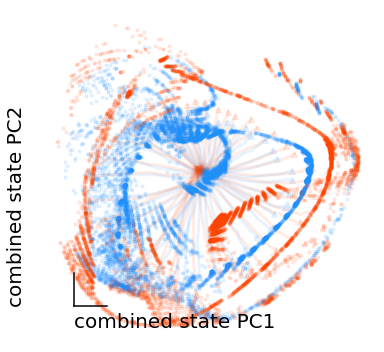

In [33]:
plot_h = 'h'
use_pcs = True
lf = 'lesion_fps_review'

for cluster_name in ['Anti','Delayed Response',]: #EDIT WHICH CLUSTERS TO STUDY 
    
    lesion_cluster = cluster_number[cluster_name]+1
    lesion_units_list = cluster_var['lesion_units_list'][lesion_cluster]

    for rule in ['delaygo',]: #EDIT WHICH TASK TO STUDY
        
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        _,h_l = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units_list)
        _,h_full = gen_X_from_model_dir(m,trial)

        B = np.shape(trial.y_loc)[1]

        for epoch in ['stim1',]: #EDIT WHICH EPOCH TO STUDY

            if epoch == 'stim1':
                q_thresh = 1e-7
            else:
                q_thresh = 1e-4


            T_inds = get_T_inds(trial,epoch)

            #if trials have diff inputs, concat fps from diff trials
            if np.any(np.diff(trial.x[T_inds[0],:,:],axis = 0)):
                skip_trials = 2
            else:
                skip_trials = int(B)

            #Make fp_set
            fps_l = []
            fps_all = []

            for trial_num in range(0,int(B),2):

                out_theta = int(180*trial.y_loc[-1,trial_num]/np.pi)

                filename,_ = get_filename_fp(trial,epoch,trial_num)

                f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(lesion_cluster),rule,filename)
                fps_l = append_fps(f, fps_all = fps_l, q_thresh = q_thresh, trial_num = trial_num)

                f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(0),rule,filename)
                fps_all = append_fps(f, fps_all = fps_all, q_thresh = q_thresh, trial_num = trial_num)

            #####do PCA on combined fps for viz axes
            if use_pcs=='fp':
                pca = PCA(n_components = 10)
                fps_pc = pca.fit_transform(np.append(fps_all,fps_l,axis = 0) )

                D_all = pca.components_
                x_label = 'combined FP PC1'
                y_label = 'combined FP PC2'
                axes_labels = [x_label,y_label]
            elif use_pcs=='out':
                D_all = w_out[:,1:].T

                x_label = 'output 1'
                y_label = 'output 2'
                axes_labels = [x_label,y_label]
            else:
                pca = PCA(n_components = 10)
                h_cat = np.append(h_full[:,:,-1],h_l[:,:,-1],axis = 1).T
                fps_pc = pca.fit_transform(h_cat)

                D_all = pca.components_
                x_label = 'combined state PC1'
                y_label = 'combined state PC2'
                axes_labels = [x_label,y_label]


            #PLOT FPS
            fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
            ax = plt.subplot(1,1,1)
            al = .1

            if plot_h:
                for t in range(0,B,2):
                    h = h_full[:,t,T_inds]
                    h_in_D = np.dot(D_all,h)
                    plt.plot(h_in_D[0,:],h_in_D[1,:],'-', c = 'dodgerblue',linewidth = 3, alpha = al)
                    plt.plot(h_in_D[0,0],h_in_D[1,0],'x', c = 'dodgerblue',linewidth = 3, alpha = al)
                    plt.plot(h_in_D[0,-1],h_in_D[1,-1],'^', c = 'dodgerblue',linewidth = 3, alpha = al)

                    h = h_l[:,t,T_inds]
                    h_in_D = np.dot(D_all,h)
                    plt.plot(h_in_D[0,:],h_in_D[1,:],'-', c = 'orangered',linewidth = 3, alpha = al)
                    plt.plot(h_in_D[0,0],h_in_D[1,0],'x', c = 'orangered',linewidth = 3, alpha = al)
                    plt.plot(h_in_D[0,-1],h_in_D[1,-1],'^', c = 'orangered',linewidth = 3, alpha = al)

            fp_in_D = np.dot(D_all,fps_all.T)
            plt.plot(fp_in_D[0,:],fp_in_D[1,:],'.', c = 'dodgerblue',alpha = al)

            fp_in_D = np.dot(D_all,fps_l.T)
            plt.plot(fp_in_D[0,:],fp_in_D[1,:],'.', c = 'orangered',alpha = al)

            #make axes nice

#             if ~use_pcs:
#                 plt.ylim([-1.5,1.5])
#                 plt.xlim([-1.5,1.5])

            make_lil_axes(ax,axes_labels,fontsize = 20,fac_len = 1)
            epoch_name, rule_name, _, _ = take_names(epoch,rule,epoch_axes = epoch, h_epoch = epoch)
            tit = 'Lesion: '+ cluster_name + ' \n during ' + rule_name +' '+epoch_name
            plt.title(tit,fontsize = 18)


            #save figs
            figname = '_'.join((cluster_name,rule_name,epoch_name,x_label))
            plt.savefig(os.path.join(figpath,figname+'.pdf'))

In [71]:
import imageio
from tools_lnd import comp_eig_decomp

In [72]:
fp_struct.keys()

['qstar',
 'inputs',
 'epoch_inds',
 'out_dir',
 'noise_var',
 'J_xstar',
 'xstar',
 'lesion_units',
 'state_traj']

In [75]:
np.shape(eig_decomps)

(25,)

NameError: name 'fp_ind' is not defined

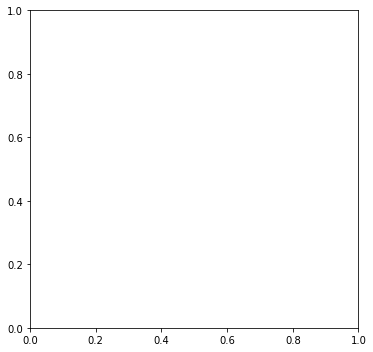

In [73]:
LAG = 10 #how many timesteps to show in each frame (length of tail on state traj)
lim=1.5 #set xy lims so all axes are the same in ea fram
epoch_name, rule_name, _, _ = take_names(epoch,rule,epoch_axes = epoch, h_epoch = epoch)
q_thresh = 1e-8
al = .5

movie_dir = os.path.join(figpath,'epoch_dynamics_gif/') #set path for where all the movies go
if not os.path.exists(movie_dir):
    os.makedirs(movie_dir)

fig_title = '_'.join((cluster_name,rule_name,epoch_name,x_label,'mov'))
movie_dir = os.path.join(fldr,fig_title) #set path for where all the frames go (concatenate at the end)
if not os.path.exists(movie_dir):
    os.makedirs(movie_dir)


fig = plt.figure(figsize=(10,5),tight_layout=True,facecolor='white')

use_pcs = 'h'

#####do PCA on combined fps for viz axes
if use_pcs=='out':
    D_all = w_out[:,1:].T

    x_label = 'output 1'
    y_label = 'output 2'
    axes_labels = [x_label,y_label]
else:
    pca = PCA(n_components = 10)
    h_cat = np.append(h_full[:,:,-1],h_l[:,:,-1],axis = 1).T
    fps_pc = pca.fit_transform(h_cat)

    D_all = pca.components_
    x_label = 'combined state PC1'
    y_label = 'combined state PC2'
    axes_labels = [x_label,y_label]

movie_inds = T_inds[1:-1:2] #frame every 6 timesteps
mov_i = 0

for t in range(0,int(B),2):
    
    for im_num in movie_inds:
        
        ax = plt.subplot(121)
        ax.clear()

        out_theta = int(180*trial.y_loc[-1,t]/np.pi)

        filename,_ = get_filename_fp(trial,epoch,t)

        f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(lesion_cluster),rule,filename)
        fp_struct = np.load(f)
        fp_use = np.where(fp_struct['qstar']<q_thresh)[0]
        J_xstar = fp_struct['J_xstar'][fp_use,:,:]
        sorted_fps = fp_struct['xstar'][fp_use,:]
        eig_decomps = comp_eig_decomp(J_xstar)
        stable_fps = np.max(eig_decomps[fp_ind]['evals'].real)>.999
        fps_l = sorted_fps[stable_fps,:]
        if t>0:
            fps_l_cat = np.append(fps_l_cat,fps_l,axis = 0) 
        else:
            fps_l_cat = fps_l

        f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(0),rule,filename)
        fp_struct = np.load(f)
        fp_use = np.where(fp_struct['qstar']<q_thresh)[0]
        J_xstar = fp_struct['J_xstar'][fp_use,:,:]
        sorted_fps = fp_struct['xstar'][fp_use,:]
        eig_decomps = comp_eig_decomp(J_xstar)
        stable_fps = np.max(eig_decomps[fp_ind]['evals'].real)>.999
        fps_all = sorted_fps[stable_fps,:]
        if t>0:
            fps_all_cat = np.append(fps_all_cat,fps_all,axis = 0) 
        else:
            fps_all_cat = fps_all

        ##plot trajectory

        plot_set_start = np.max([T_inds[0],im_num-LAG])
        plot_set = range(plot_set_start,im_num)

        h = h_full[:,t,plot_set]
        h_in_D = np.dot(D_all,h)
        plt.plot(h_in_D[0,:],h_in_D[1,:],'-', c = 'dodgerblue',linewidth = 3, alpha = al)
        plt.plot(h_in_D[0,0],h_in_D[1,0],'x', c = 'dodgerblue',linewidth = 3, alpha = al)
        plt.plot(h_in_D[0,-1],h_in_D[1,-1],'^', c = 'dodgerblue',linewidth = 3, alpha = al)

        h = h_l[:,t,plot_set]
        h_in_D = np.dot(D_all,h)
        plt.plot(h_in_D[0,:],h_in_D[1,:],'-', c = 'orangered',linewidth = 3, alpha = al)
        plt.plot(h_in_D[0,0],h_in_D[1,0],'x', c = 'orangered',linewidth = 3, alpha = al)
        plt.plot(h_in_D[0,-1],h_in_D[1,-1],'^', c = 'orangered',linewidth = 3, alpha = al)

        fp_in_D = np.dot(D_all,fps_all.T)
        plt.plot(fp_in_D[0,:],fp_in_D[1,:],'o', c = 'dodgerblue',alpha = al)
        fp_in_D = np.dot(D_all,fps_all_cat.T)
        plt.plot(fp_in_D[0,:],fp_in_D[1,:],'.', c = 'dodgerblue',alpha = al/50)

        fp_in_D = np.dot(D_all,fps_l.T)
        plt.plot(fp_in_D[0,:],fp_in_D[1,:],'o', c = 'orangered',alpha = al)
        fp_in_D = np.dot(D_all,fps_l_cat.T)
        plt.plot(fp_in_D[0,:],fp_in_D[1,:],'.', c = 'orangered',alpha = al/50)
            
        ### ax labels
        ###set x,y lims
        plt.ylim([-lim,lim])
        plt.xlim([-lim,lim])
        make_lil_axes(ax,axes_labels,fontsize = 20,fac_len = 1)

        mov_i += 1 
        plt.savefig(movie_dir +'/'+ str(mov_i) + '.png')
        print(movie_dir +'/'+ str(mov_i) + '.png')

images = []
for t in range(1,mov_i):#T*xt):
    filename = movie_dir +'/'+ str(t) + '.png'
    images.append(imageio.imread(filename))

imageio.mimsave(movie_dir+'/movie.gif', images)

In [50]:
images = []
for t in range(1,mov_i):#T*xt):
    filename = movie_dir +'/'+ str(t) + '.png'
    images.append(imageio.imread(filename))

imageio.mimsave(movie_dir+'/movie.gif', images)